Referred and credit goes to these notebooks and authors

1. https://www.kaggle.com/code/masayakawamata/s5e2-te-xgb
2. https://www.kaggle.com/code/cdeotte/two-baseline-models-lb-38-91
3. https://www.kaggle.com/code/kumarandatascientist/agentic-ai-pipeline-baseline-models-backpack-v1

# Included LLM AI agentic approach AIAgencticOptimizedCodeLLM model !! reuse this LLM model has the below major features

Link here https://www.kaggle.com/models/andrometocs/aiagenticoptimizedcodellm/other/default/1 purpose of this model script useful for AI agentic llm pipeline will provide better model suggestions and custom user prompt queries it will provide better new versions of optimized code !!

1. You can follow create text version of your model metric file and .py file
2. using gemini api call it will provide better improvement and you can prompt here itself new optimized code .py file
3. finally LLM show, look and feel HTML response both ML model metric improvement suggestion and new optimized code to use it !! using text generated LLLM responses always keep fine tuning your new versions of the code here!!

Any queries reach me in comments follow me in linkedin here https://www.linkedin.com/in/kumarankanniappan/ for linkedin articles related to AI, ML, LLM and other professional related contents, thank you happy kaggling

**Here is output example usage !! iterative refining your code !! using AIAgencticOptimizedCodeLLM !!**
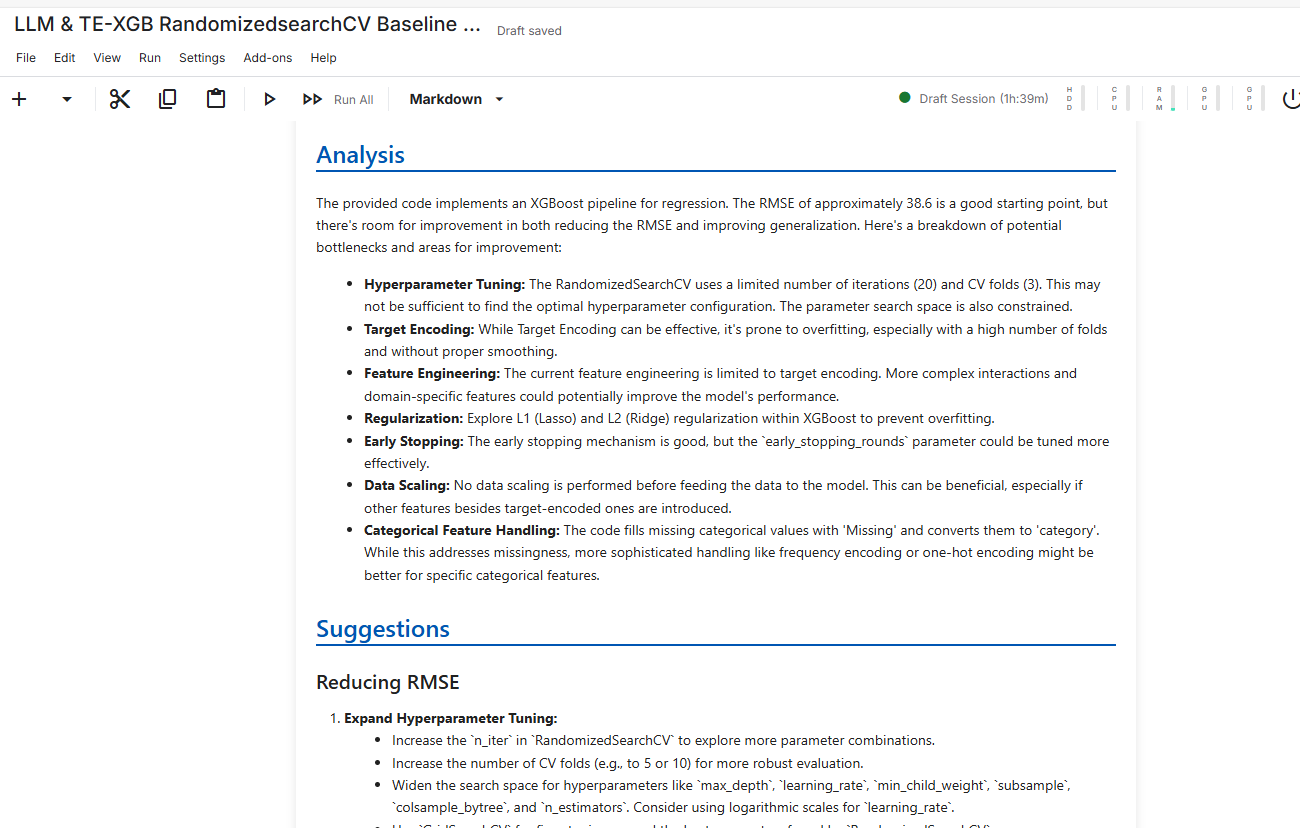

Below is a detailed technical explanation of the code, which implements an end-to-end pipeline for training an XGBoost model using target-encoded features, hyperparameter tuning, and early stopping—all while logging execution times and displaying progress via a tqdm progress bar.

---

## 1. **Imports and Setup**

- **Standard Libraries:**  
  - `pandas`, `numpy`: For data manipulation and numerical computations.  
  - `time`: To record execution times for different pipeline stages.  
  - `warnings`: To suppress warnings for cleaner output.

- **Target Encoding:**  
  - `cuml.preprocessing.TargetEncoder`: This is part of the RAPIDS cuML library. It provides a GPU-accelerated target encoding method. Target encoding replaces categorical variables with a statistic (here, the mean of the target) computed over the categories.  
  *(If you do not have RAPIDS, you might need to substitute with an alternative target encoder, for example from the `category_encoders` package.)*

- **Machine Learning and Model Evaluation:**  
  - `sklearn.model_selection`: Provides tools for splitting the data (`train_test_split`) and for hyperparameter tuning (`RandomizedSearchCV` and `KFold` for cross-validation).  
  - `sklearn.metrics.mean_squared_error`: Used for evaluating the model’s performance (the RMSE metric is derived from the MSE).  
  - `xgboost`: Contains the `XGBRegressor` model and a callback interface (`callback`) for custom training behavior.

- **Progress Bar and Parameter Distributions:**  
  - `tqdm.auto.tqdm`: Used to show a progress bar during model training.  
  - `scipy.stats.uniform`, `randint`: Provide probability distributions to sample hyperparameters in `RandomizedSearchCV`.

---

## 2. **Custom Training Callback**

### `TqdmCallback` Class

- **Purpose:**  
  To integrate the tqdm progress bar with XGBoost’s training loop, giving real-time feedback on the training progress (e.g., current RMSE on the validation set).

- **Key Methods:**
  - `__init__(self, total)`:  
    Initializes a tqdm progress bar with a specified total number of iterations (boosting rounds).
  - `after_iteration(self, model, epoch, evals_log)`:  
    This method is called after each boosting iteration. It:
    - Checks if evaluation metrics (specifically RMSE on the validation set) are available in `evals_log`.
    - Updates the tqdm progress bar with the latest RMSE value.
    - Calls `pbar.update(1)` to advance the progress bar by one iteration.
    - Returns `False` to signal that training should continue.
  - `after_training(self, model)`:  
    Closes the progress bar and returns the model (a requirement by the XGBoost callback API).

---

## 3. **The Pipeline Class: `XGBPipeline`**

This class encapsulates all major steps: data preprocessing, hyperparameter tuning, model training, test prediction, and submission file generation.

### **Initialization: `__init__`**

- **Inputs:**  
  - `train` and `test`: DataFrames containing training and test data.  
  - `target`: The name of the target variable (e.g., `"Price"`).  
  - `features`: A list of feature names (all columns except the target).  
  - `cats`: List of categorical columns (for filling missing values and casting to `category`).  
  - `te_params`: (Optional) A dictionary with parameters for the TargetEncoder. Defaults are provided if not specified.  
  - `sample_frac`: Fraction of the training data to use for hyperparameter tuning.  
  - `random_state`: Seed for reproducibility.

- **What It Does:**  
  - Creates copies of the input data.
  - Initializes the TargetEncoder with provided or default parameters.
  - Sets placeholders for the best hyperparameters, model, best iteration, and a combined list of all features.

### **Preprocessing: `preprocess_data`**

- **Tasks:**
  - **Target Encoding:**  
    For each feature in `self.features`, it creates a new column (prefixed with `"TE_"`) containing the target-encoded values.  
    - For the training set: `self.TE.fit_transform(...)` is used to compute and apply the encoding.
    - For the test set: `self.TE.transform(...)` applies the learned encoding.
  - **Handling Categorical Variables:**  
    Fills missing values in the categorical columns (specified in `self.cats`) with the string `"Missing"` and casts them as `category`.
  - **Feature Combination:**  
    Combines the original features and the newly created target-encoded features into `self.all_features`.

- **Timing:**  
  Records and prints the time taken for preprocessing.

### **Hyperparameter Tuning: `hyperparameter_tuning`**

- **Process:**
  - Samples a fraction (`sample_frac`) of the training data to speed up the tuning process.
  - **Parameter Search Space:**  
    Uses distributions for various XGBoost hyperparameters:
    - `"max_depth"`: Integer between 3 and 10.
    - `"learning_rate"`: Float between 0.01 and 0.1.
    - `"min_child_weight"`: Integer between 1 and 100.
    - `"subsample"` and `"colsample_bytree"`: Floats between 0.5 and 1.0.
    - `"n_estimators"`: Integer between 500 and 1500.
  - Sets up a base `XGBRegressor` with GPU acceleration (`tree_method="gpu_hist"`) and categorical support enabled.
  - **RandomizedSearchCV:**  
    Runs 15 iterations (combinations) with 3-fold cross-validation using the negative root mean squared error as the scoring metric.
  - **Results:**  
    Stores the best parameters and the best CV RMSE (by negating the score) into class attributes.

- **Timing:**  
  Logs the duration of the hyperparameter tuning process.

### **Training Final Model: `train_final_model`**

- **Process:**
  - **Data Splitting:**  
    Splits the full training data into a training set and a hold-out validation set (80/20 split) using `train_test_split`.
  - **Model Initialization:**  
    Instantiates a new `XGBRegressor` using the best hyperparameters found.
  - **Early Stopping & Progress Monitoring:**  
    Uses the custom `TqdmCallback` to display a progress bar during training.  
    The model is trained with early stopping (e.g., stop if no improvement for 100 rounds).
  - **Evaluation:**  
    After training, the model’s best iteration (i.e., the number of rounds at which the validation score was optimal) is recorded. Predictions on the hold-out set are made, and the RMSE is computed and printed.

- **Timing:**  
  Measures and prints the time taken to train the final model.

### **Prediction and Submission:**

- **`predict_test`:**  
  Generates predictions on the test dataset using the best iteration from training. Also logs the time taken for test prediction.
- **`save_submission`:**  
  Creates a submission CSV file containing the test IDs and corresponding predictions. Logs the file save time.

### **Pipeline Execution: `run_pipeline`**

- **Workflow:**  
  Calls the following methods in order:
  1. `preprocess_data`
  2. `hyperparameter_tuning`
  3. `train_final_model`
  4. `predict_test`
  5. `save_submission`
  
  It logs the overall pipeline execution time.

---

## 4. **Example Usage (Main Block)**

- **Data Loading:**  
  The main block reads in the training and test CSV files. It also reads an extra training dataset and concatenates it with the primary training set.
- **Configuration:**  
  Defines:
  - The target column (e.g., `"Price"`).
  - The feature columns (all columns except the target).
  - The categorical columns (all columns except `Price` and, in this example, `"Weight Capacity (kg)"`).
- **Pipeline Instantiation and Execution:**  
  An instance of `XGBPipeline` is created with the loaded data and configuration. Then, the `run_pipeline` method is called, which executes all the steps described above.

---

## Summary

This code implements a modular pipeline for training an XGBoost model with the following key features:

- **Data Preprocessing:**  
  Uses target encoding to convert categorical variables into numerical features based on the target statistics. Also handles missing values and type conversion.

- **Hyperparameter Tuning:**  
  Uses RandomizedSearchCV with a reduced search space and a subset of data to quickly find an optimal set of parameters based on cross-validated RMSE.

- **Model Training:**  
  Trains an XGBoost regressor using the tuned hyperparameters with early stopping on a hold-out validation set. A custom tqdm callback provides a live progress bar with RMSE updates.

- **Test Prediction and Submission:**  
  Generates predictions on the test set using the best boosting iteration and saves them to a CSV file.

- **Time Logging:**  
  Each major step is timed, which helps in diagnosing bottlenecks and understanding overall pipeline performance.

This modular, well-documented, and time-monitored pipeline makes it easier to manage, debug, and extend  machine learning workflow.

In [ ]:
import os
import time
import random
import warnings
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from cuml.preprocessing import TargetEncoder  # GPU-accelerated target encoding

# PyTorch (for XGBoost GPU acceleration, if applicable)
import torch

# Scikit-learn imports for cross-validation and metrics
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# XGBoost modules
from xgboost import XGBRegressor, callback

# For probability distributions
from scipy.stats import uniform, randint

warnings.simplefilter('ignore')

# ------------------------------ Reproducibility ------------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# ------------------------ Custom Callback for tqdm --------------------------
class TqdmCallback(callback.TrainingCallback):
    """
    Custom XGBoost training callback that uses tqdm to display a progress bar
    and current RMSE for each iteration during training.
    """
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Training Progress", unit="iter")

    def after_iteration(self, model, epoch, evals_log):
        if evals_log and "validation_0" in evals_log and "rmse" in evals_log["validation_0"]:
            current_rmse = evals_log["validation_0"]["rmse"][-1]
            self.pbar.set_postfix(rmse=f"{current_rmse:.4f}")
        self.pbar.update(1)
        return False  # Continue training

    def after_training(self, model):
        self.pbar.close()
        return model

# ----------------------- XGBPipeline Class Definition -------------------------
class XGBPipeline:
    """
    Pipeline for preprocessing, hyperparameter tuning, final model training,
    and test predictions using XGBoost.
    """
    def __init__(self, train: pd.DataFrame, test: pd.DataFrame,
                 target: str, features: list, cats: list,
                 te_params: dict = None,
                 sample_frac: float = 0.5,
                 random_state: int = 42):
        self.train = train.copy()
        self.test = test.copy()
        self.target = target
        self.features = features
        self.cats = cats
        self.sample_frac = sample_frac
        self.random_state = random_state
        
        if te_params is None:
            te_params = {'n_folds': 25, 'smooth': 20, 'split_method': 'random', 'stat': 'mean'}
        self.te_params = te_params
        
        self.TE = TargetEncoder(**self.te_params)
        
        self.best_params = None
        self.best_cv_rmse = None
        self.model = None
        self.best_iteration = None
        self.all_features = None
        self.metrics_log = []
    
    def log(self, message: str):
        print(message)
        self.metrics_log.append(message)
    
    def save_metrics_log(self, filename="ml_model_metrics_analysis.txt"):
        with open(filename, "w") as f:
            for message in self.metrics_log:
                f.write(message + "\n")
        self.log(f"Metrics log saved to {filename}.")

    def preprocess_data(self):
        start_time = time.time()
        self.log("Starting data preprocessing...")
        # --- Target Encoding: Create TE_feature for each original feature.
        for col in self.features:
            self.train[f"TE_{col}"] = self.TE.fit_transform(self.train[col], self.train[self.target])
            self.test[f"TE_{col}"] = self.TE.transform(self.test[col])
        
        # Ensure categorical columns are filled and cast as 'category'
        self.train[self.cats] = self.train[self.cats].fillna('Missing').astype('category')
        self.test[self.cats] = self.test[self.cats].fillna('Missing').astype('category')
        
        # --- Feature Scaling: For numeric features, fill missing values and scale.
        # We'll use StandardScaler here.
        num_features = [col for col in self.features if col not in self.cats]
        scaler = StandardScaler()
        self.train[num_features] = scaler.fit_transform(self.train[num_features])
        self.test[num_features] = scaler.transform(self.test[num_features])
        self.scaler = scaler  # save scaler if needed
        
        # --- Combine Original and TE features
        self.all_features = self.features + [f"TE_{col}" for col in self.features]
        elapsed = time.time() - start_time
        self.log(f"Preprocessing complete. All features created: {self.all_features} (Time taken: {elapsed:.2f} sec)")

    def hyperparameter_tuning(self):
        start_time = time.time()
        self.log("Starting hyperparameter tuning using RandomizedSearchCV with parallel processing...")
        # Use a subset of data for faster tuning.
        train_sample = self.train.sample(frac=self.sample_frac, random_state=self.random_state)
        
        # Expanded search space:
        param_distributions = {
            "max_depth": randint(3, 12),
            "learning_rate": uniform(0.005, 0.095),  # [0.005, 0.1)
            "min_child_weight": randint(1, 50),
            "subsample": uniform(0.5, 0.5),           # between 0.5 and 1.0
            "colsample_bytree": uniform(0.5, 0.5),      # between 0.5 and 1.0
            "n_estimators": randint(500, 2000)
        }
        
        base_xgb = XGBRegressor(
            tree_method="gpu_hist",
            enable_categorical=True,
            random_state=self.random_state,
        )
        
        random_search = RandomizedSearchCV(
            estimator=base_xgb,
            param_distributions=param_distributions,
            n_iter=50,  # Increase iterations for a finer search.
            scoring="neg_root_mean_squared_error",
            cv=3,
            verbose=2,
            random_state=self.random_state,
            n_jobs=-1  # Parallel processing
        )
        
        random_search.fit(train_sample[self.all_features], train_sample[self.target])
        self.best_params = random_search.best_params_
        self.best_cv_rmse = -random_search.best_score_
        elapsed = time.time() - start_time
        self.log("Hyperparameter tuning complete.")
        self.log(f"Best parameters found: {self.best_params}")
        self.log(f"Best CV RMSE: {self.best_cv_rmse:.4f}")
        self.log(f"Hyperparameter tuning time: {elapsed:.2f} seconds")

    def train_final_model(self, early_stopping_rounds: int = 100):
        start_time = time.time()
        self.log("Training final model using XGBoost with best hyperparameters...")
        X_train, X_val, y_train, y_val = train_test_split(
            self.train[self.all_features], self.train[self.target],
            test_size=0.2, random_state=self.random_state
        )
        
        self.model = XGBRegressor(
            tree_method="gpu_hist",
            enable_categorical=True,
            random_state=self.random_state,
            **self.best_params
        )
        
        tqdm_cb = TqdmCallback(total=self.model.get_params()["n_estimators"])
        self.model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            early_stopping_rounds=early_stopping_rounds,
            callbacks=[tqdm_cb],
            verbose=False
        )
        
        self.best_iteration = self.model.best_iteration
        val_preds = self.model.predict(X_val, iteration_range=(0, self.best_iteration + 1))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        elapsed = time.time() - start_time
        self.log("Final model training complete.")
        self.log(f"Hold-out Validation RMSE: {val_rmse:.4f}")
        self.log(f"Best Iteration: {self.best_iteration}")
        self.log(f"Final model training time: {elapsed:.2f} seconds")

    def predict_test(self):
        start_time = time.time()
        test_predictions = self.model.predict(self.test[self.all_features],
                                               iteration_range=(0, self.best_iteration + 1))
        elapsed = time.time() - start_time
        self.log(f"Test prediction time: {elapsed:.2f} seconds")
        return test_predictions

    def save_submission(self, predictions, filename="submission.csv"):
        start_time = time.time()
        sub = pd.DataFrame({"id": self.test.index, self.target: predictions})
        sub.to_csv(filename, index=False)
        elapsed = time.time() - start_time
        self.log(f"Submission saved to {filename}. (Time taken: {elapsed:.2f} seconds)")

    def run_pipeline(self):
        overall_start = time.time()
        self.log("Starting pipeline execution...")
        
        self.preprocess_data()
        self.hyperparameter_tuning()
        self.train_final_model()
        predictions = self.predict_test()
        self.save_submission(predictions)
        
        overall_elapsed = time.time() - overall_start
        self.log("Pipeline execution complete.")
        self.log(f"Total pipeline time: {overall_elapsed:.2f} seconds")
        self.save_metrics_log()


In [ ]:


###############################################################################
# TE & XGB pipeline Usage
###############################################################################

if __name__ == "__main__":
    # Load the datasets.
    train = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv", index_col='id')
    train_extra = pd.read_csv("/kaggle/input/playground-series-s5e2/training_extra.csv", index_col='id')
    train = pd.concat([train, train_extra], axis=0, ignore_index=True)
    test = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv", index_col='id')

    # Define target and feature columns.
    target = "Price"
    features = [col for col in train.columns if col != target]
    
    # Define categorical columns (example: all columns except Price and Weight Capacity)
    cats = [col for col in train.columns if col not in [target, "Weight Capacity (kg)"]]
    
    # Initialize and run the pipeline.
    pipeline = XGBPipeline(train=train, test=test, target=target, features=features, cats=cats)
    pipeline.run_pipeline()


In [ ]:
%%writefile xgb_pipeline_with_tqdb_callback.py
import os
import time
import random
import warnings
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from cuml.preprocessing import TargetEncoder  # GPU-accelerated target encoding

# PyTorch (for XGBoost GPU acceleration, if applicable)
import torch

# Scikit-learn imports for cross-validation and metrics
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# XGBoost modules
from xgboost import XGBRegressor, callback

# For probability distributions
from scipy.stats import uniform, randint

warnings.simplefilter('ignore')

# ------------------------------ Reproducibility ------------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# ------------------------ Custom Callback for tqdm --------------------------
class TqdmCallback(callback.TrainingCallback):
    """
    Custom XGBoost training callback that uses tqdm to display a progress bar
    and current RMSE for each iteration during training.
    """
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Training Progress", unit="iter")

    def after_iteration(self, model, epoch, evals_log):
        if evals_log and "validation_0" in evals_log and "rmse" in evals_log["validation_0"]:
            current_rmse = evals_log["validation_0"]["rmse"][-1]
            self.pbar.set_postfix(rmse=f"{current_rmse:.4f}")
        self.pbar.update(1)
        return False  # Continue training

    def after_training(self, model):
        self.pbar.close()
        return model

# ----------------------- XGBPipeline Class Definition -------------------------
class XGBPipeline:
    """
    Pipeline for preprocessing, hyperparameter tuning, final model training,
    and test predictions using XGBoost.
    """
    def __init__(self, train: pd.DataFrame, test: pd.DataFrame,
                 target: str, features: list, cats: list,
                 te_params: dict = None,
                 sample_frac: float = 0.5,
                 random_state: int = 42):
        self.train = train.copy()
        self.test = test.copy()
        self.target = target
        self.features = features
        self.cats = cats
        self.sample_frac = sample_frac
        self.random_state = random_state
        
        if te_params is None:
            te_params = {'n_folds': 25, 'smooth': 20, 'split_method': 'random', 'stat': 'mean'}
        self.te_params = te_params
        
        self.TE = TargetEncoder(**self.te_params)
        
        self.best_params = None
        self.best_cv_rmse = None
        self.model = None
        self.best_iteration = None
        self.all_features = None
        self.metrics_log = []
    
    def log(self, message: str):
        print(message)
        self.metrics_log.append(message)
    
    def save_metrics_log(self, filename="ml_model_metrics_analysis.txt"):
        with open(filename, "w") as f:
            for message in self.metrics_log:
                f.write(message + "\n")
        self.log(f"Metrics log saved to {filename}.")

    def preprocess_data(self):
        start_time = time.time()
        self.log("Starting data preprocessing...")
        # --- Target Encoding: Create TE_feature for each original feature.
        for col in self.features:
            self.train[f"TE_{col}"] = self.TE.fit_transform(self.train[col], self.train[self.target])
            self.test[f"TE_{col}"] = self.TE.transform(self.test[col])
        
        # Ensure categorical columns are filled and cast as 'category'
        self.train[self.cats] = self.train[self.cats].fillna('Missing').astype('category')
        self.test[self.cats] = self.test[self.cats].fillna('Missing').astype('category')
        
        # --- Feature Scaling: For numeric features, fill missing values and scale.
        # We'll use StandardScaler here.
        num_features = [col for col in self.features if col not in self.cats]
        scaler = StandardScaler()
        self.train[num_features] = scaler.fit_transform(self.train[num_features])
        self.test[num_features] = scaler.transform(self.test[num_features])
        self.scaler = scaler  # save scaler if needed
        
        # --- Combine Original and TE features
        self.all_features = self.features + [f"TE_{col}" for col in self.features]
        elapsed = time.time() - start_time
        self.log(f"Preprocessing complete. All features created: {self.all_features} (Time taken: {elapsed:.2f} sec)")

    def hyperparameter_tuning(self):
        start_time = time.time()
        self.log("Starting hyperparameter tuning using RandomizedSearchCV with parallel processing...")
        # Use a subset of data for faster tuning.
        train_sample = self.train.sample(frac=self.sample_frac, random_state=self.random_state)
        
        # Expanded search space:
        param_distributions = {
            "max_depth": randint(3, 12),
            "learning_rate": uniform(0.005, 0.095),  # [0.005, 0.1)
            "min_child_weight": randint(1, 50),
            "subsample": uniform(0.5, 0.5),           # between 0.5 and 1.0
            "colsample_bytree": uniform(0.5, 0.5),      # between 0.5 and 1.0
            "n_estimators": randint(500, 2000)
        }
        
        base_xgb = XGBRegressor(
            tree_method="gpu_hist",
            enable_categorical=True,
            random_state=self.random_state,
        )
        
        random_search = RandomizedSearchCV(
            estimator=base_xgb,
            param_distributions=param_distributions,
            n_iter=50,  # Increase iterations for a finer search.
            scoring="neg_root_mean_squared_error",
            cv=3,
            verbose=2,
            random_state=self.random_state,
            n_jobs=-1  # Parallel processing
        )
        
        random_search.fit(train_sample[self.all_features], train_sample[self.target])
        self.best_params = random_search.best_params_
        self.best_cv_rmse = -random_search.best_score_
        elapsed = time.time() - start_time
        self.log("Hyperparameter tuning complete.")
        self.log(f"Best parameters found: {self.best_params}")
        self.log(f"Best CV RMSE: {self.best_cv_rmse:.4f}")
        self.log(f"Hyperparameter tuning time: {elapsed:.2f} seconds")

    def train_final_model(self, early_stopping_rounds: int = 100):
        start_time = time.time()
        self.log("Training final model using XGBoost with best hyperparameters...")
        X_train, X_val, y_train, y_val = train_test_split(
            self.train[self.all_features], self.train[self.target],
            test_size=0.2, random_state=self.random_state
        )
        
        self.model = XGBRegressor(
            tree_method="gpu_hist",
            enable_categorical=True,
            random_state=self.random_state,
            **self.best_params
        )
        
        tqdm_cb = TqdmCallback(total=self.model.get_params()["n_estimators"])
        self.model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            early_stopping_rounds=early_stopping_rounds,
            callbacks=[tqdm_cb],
            verbose=False
        )
        
        self.best_iteration = self.model.best_iteration
        val_preds = self.model.predict(X_val, iteration_range=(0, self.best_iteration + 1))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        elapsed = time.time() - start_time
        self.log("Final model training complete.")
        self.log(f"Hold-out Validation RMSE: {val_rmse:.4f}")
        self.log(f"Best Iteration: {self.best_iteration}")
        self.log(f"Final model training time: {elapsed:.2f} seconds")

    def predict_test(self):
        start_time = time.time()
        test_predictions = self.model.predict(self.test[self.all_features],
                                               iteration_range=(0, self.best_iteration + 1))
        elapsed = time.time() - start_time
        self.log(f"Test prediction time: {elapsed:.2f} seconds")
        return test_predictions

    def save_submission(self, predictions, filename="submission.csv"):
        start_time = time.time()
        sub = pd.DataFrame({"id": self.test.index, self.target: predictions})
        sub.to_csv(filename, index=False)
        elapsed = time.time() - start_time
        self.log(f"Submission saved to {filename}. (Time taken: {elapsed:.2f} seconds)")

    def run_pipeline(self):
        overall_start = time.time()
        self.log("Starting pipeline execution...")
        
        self.preprocess_data()
        self.hyperparameter_tuning()
        self.train_final_model()
        predictions = self.predict_test()
        self.save_submission(predictions)
        
        overall_elapsed = time.time() - overall_start
        self.log("Pipeline execution complete.")
        self.log(f"Total pipeline time: {overall_elapsed:.2f} seconds")
        self.save_metrics_log()


In [ ]:
# Move all necessary files
!cp -r /kaggle/input/aiagenticoptimizedcodellm/other/default/1/* /kaggle/working/
import sys 
sys.path.append('/kaggle/working/AIAgenticOptimizedCodeLLM.py')

In [ ]:
import os
from kaggle_secrets import UserSecretsClient
from google import genai
from IPython.display import display, HTML
from AIAgenticOptimizedCodeLLM import AIAgenticOptimizedCodeLLM 


# -------------------------------------------------------------------
# Main execution
# -------------------------------------------------------------------
if __name__ == "__main__":
    # Get the API key using Kaggle's secrets (adjust as needed for your environment)
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("GOOGLE_API_KEY")

    # Define file paths for metrics, original code, and the output HTML file.
    metrics_file_path = "/kaggle/working/ml_model_metrics_analysis.txt"
    code_file_path = "/kaggle/working/xgb_pipeline_with_tqdb_callback.py"
    optimized_html_file_path = "/kaggle/working/xgb_pipeline_with_tqdb_callback_v1.html"

    # User prompt for improvements
    user_prompt = """
Please provide ways to improve the ML model metrics such as RMSE.
Additionally, share suggestions on how to generalize the ML model.
Specifically:
1. How can I reduce the RMSE score of my model?
2. How can I ensure my model generalizes well to unseen data?
3. share any deep learning with feed forward & back propagation models & any vector 
Regression with xgb, lgbm and catboost meta ensemble !!  ensemble all these meta models
and save submission.csv file similar like all these xgb pipeline features time logging & tqdm progress & callback?
"""

    optimizer = AIAgenticOptimizedCodeLLM(api_key, metrics_file_path, code_file_path, optimized_html_file_path)
    html_response = optimizer.optimize_model_code(user_prompt)

    #print("Final HTML Response:")
    #print(html_response)
    #print("Final HTML Response:")
    display(HTML(html_response))
